# Wstęp i Opis Problemu

Celem tego projektu jest zaprezentowanie procesu analizy danych giełdowych oraz zastosowania trzech różnych modeli regresji w celu przewidywania cen akcji na kolejny dzień. Projekt wykorzystuje dane historycznych notowań giełdowych, w tym ceny otwarcia, zamknięcia, najwyższe i najniższe ceny oraz wolumen handlu, pobrane ze strony giełdowej

W projekcie wykorzystano trzy różne modele regresji do przewidywania cen akcji:

Model Baseline - wyznacza cene jutrzejszą zamknięcia na podstawie dzisiejszej ceny.


Linear Regression (Regresja Liniowa): Model liniowej regresji wykorzystuje liniową zależność między cechami a cenami akcji do przewidzenia przyszłych cen.

Random Forest Regressor: Model oparty na losowym lesie, który tworzy wiele drzew regresji i łączy ich przewidywania w celu uzyskania bardziej stabilnych i precyzyjnych prognoz.

# IMPORT BIBLIOTEK

In [1]:
# Manipulacja danymi i analiza
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import pandas_ta as ta

# Manipulacja datami i czasem
import datetime
from datetime import timedelta

# Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance

# Uczenie maszynowe
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score
from sklearn.model_selection import TimeSeriesSplit

# Analiza szeregów czasowych
from statsmodels.tsa.seasonal import seasonal_decompose

# Głębokie uczenie
import keras
import tensorflow as tf
from keras.callbacks import History
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Input, Activation, concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

# Załadowanie i Przetworzenie Danych

In [2]:
# Ustaw daty początkowe i końcowe
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2019, 1, 1)

# Lista symboli
symbols = ["jsw", "pkn", "pge", "kgh"]

# Inicjalizacja listy do przechowywania danych
dfs = []

# Pobierz dane dla każdego symbolu i dodaj je do listy dfs
for symbol in symbols:
    data = web.DataReader(f"{symbol}.pl", 'stooq', start, end)
    # Dodaj kolumnę 'Symbol' z nazwą spółki
    data['Symbol'] = symbol
    dfs.append(data)


# Połącz dane w jednym DataFrame
df = pd.concat(dfs)

print(df)


               Open     High      Low    Close        Volume Symbol
Date                                                               
2018-12-28  63.1790  63.7090  62.6110  63.6710  9.890400e+04    jsw
2018-12-27  63.6520  63.7090  62.5920  62.6870  1.091690e+05    jsw
2018-12-21  63.3300  63.7280  61.5320  62.7060  3.927910e+05    jsw
2018-12-20  64.4660  65.0150  62.8950  63.6900  2.393740e+05    jsw
2018-12-19  64.6180  65.3940  63.9170  64.8640  2.419600e+05    jsw
...             ...      ...      ...      ...           ...    ...
2012-01-09  73.1836  73.8221  70.8879  70.8879  1.695135e+06    kgh
2012-01-05  73.8221  73.8857  71.1431  72.7388  7.653021e+05    kgh
2012-01-04  73.3108  74.0773  71.8441  73.3753  1.012719e+06    kgh
2012-01-03  75.4803  75.6085  72.1638  74.2054  2.108546e+06    kgh
2012-01-02  70.5692  75.9281  69.9307  75.2251  1.281064e+06    kgh

[6976 rows x 6 columns]


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6976 entries, 2018-12-28 to 2012-01-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6976 non-null   float64
 1   High    6976 non-null   float64
 2   Low     6976 non-null   float64
 3   Close   6976 non-null   float64
 4   Volume  6976 non-null   float64
 5   Symbol  6976 non-null   object 
dtypes: float64(5), object(1)
memory usage: 381.5+ KB
None
              Open         High          Low        Close        Volume
count  6976.000000  6976.000000  6976.000000  6976.000000  6.976000e+03
mean     54.127009    54.871790    53.335971    54.099929  1.363322e+06
std      36.316943    36.739688    35.826334    36.284256  1.363052e+06
min       8.264200     8.557600     8.197900     8.302000  1.708000e+04
25%      16.954000    17.247750    16.608750    16.942500  5.031138e+05
50%      49.793000    50.442000    49.225200    49.825500  1.030695e+06
75%      84.43517

In [4]:
jsw = df[df["Symbol"] == "jsw"]
pkn = df[df["Symbol"] == "pkn"]
kgh = df[df["Symbol"] == "kgh"]
pge = df[df["Symbol"] == "pge"]

In [5]:
# Inicjalizacja MinMax Scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Przeskalowanie kolumny 'Close' dla jsw
scaled_data_jsw = scaler.fit_transform(jsw[['Close']])

# Utworzenie ramki danych z przeskalowanymi danymi
scaled_data_frame_jsw = pd.DataFrame(scaled_data_jsw, columns=['Scaled Close'], index=jsw.index)

# Przeskalowanie kolumny 'Close' dla pkn
scaled_data_pkn = scaler.fit_transform(pkn[['Close']])
scaled_data_frame_pkn = pd.DataFrame(scaled_data_pkn, columns=['Scaled Close'], index=pkn.index)

# Przeskalowanie kolumny 'Close' dla pge
scaled_data_pge = scaler.fit_transform(pge[['Close']])
scaled_data_frame_pge = pd.DataFrame(scaled_data_pge, columns=['Scaled Close'], index=pge.index)

# Przeskalowanie kolumny 'Close' dla kgh
scaled_data_kgh = scaler.fit_transform(kgh[['Close']])
scaled_data_frame_kgh = pd.DataFrame(scaled_data_kgh, columns=['Scaled Close'], index=kgh.index)


# Analiza Eksploracyjna Danych

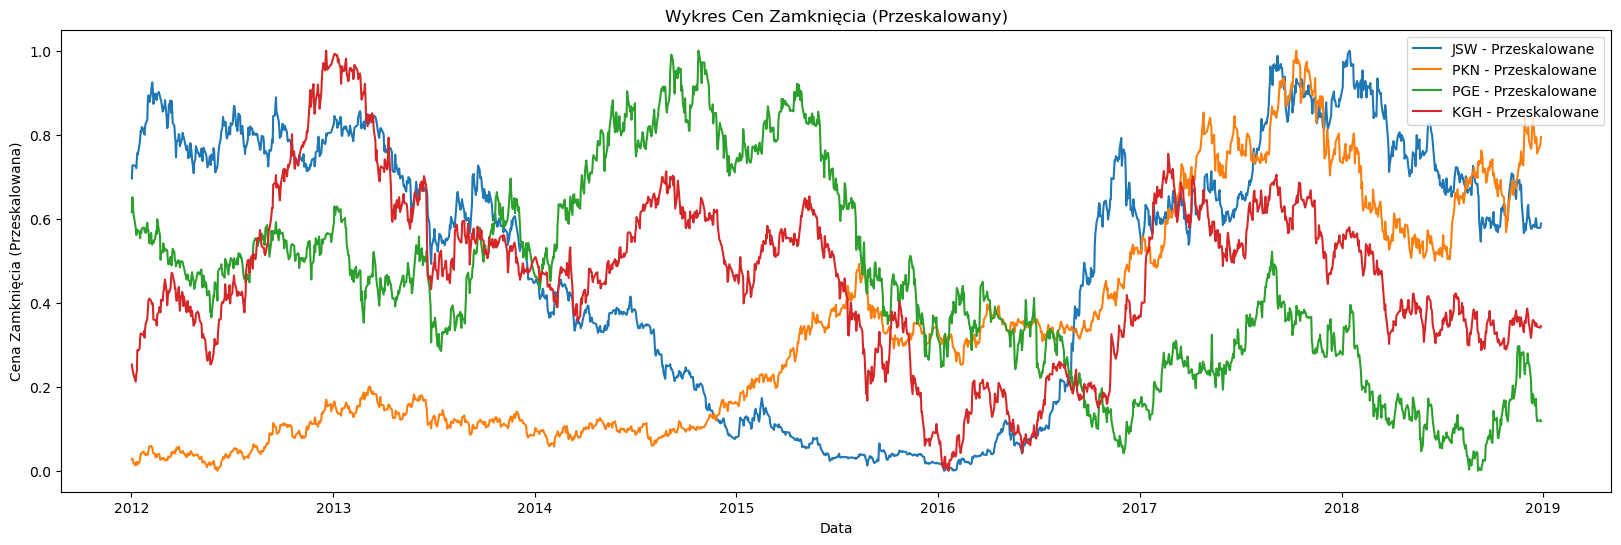

In [6]:
# Wykresy cen zamknięcia po zastosowaniu MinMaxScaler
plt.figure(figsize=(20, 6))

plt.plot(scaled_data_frame_jsw.index, scaled_data_frame_jsw['Scaled Close'], label='JSW - Przeskalowane')
plt.plot(scaled_data_frame_pkn.index, scaled_data_frame_pkn['Scaled Close'], label='PKN - Przeskalowane')
plt.plot(scaled_data_frame_pge.index, scaled_data_frame_pge['Scaled Close'], label='PGE - Przeskalowane')
plt.plot(scaled_data_frame_kgh.index, scaled_data_frame_kgh['Scaled Close'], label='KGH - Przeskalowane')

plt.xlabel('Data')
plt.ylabel('Cena Zamknięcia (Przeskalowana)')
plt.title('Wykres Cen Zamknięcia (Przeskalowany)')
plt.legend()
plt.show()

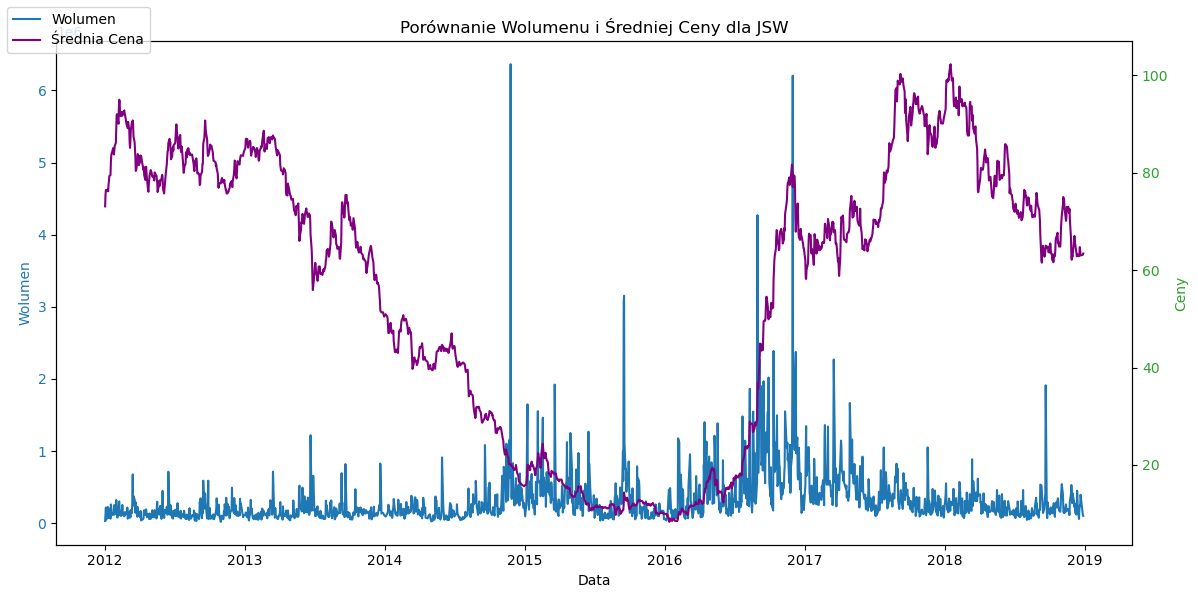

In [7]:
# Pobierz dane dla spółki JSW
jsa_data = web.DataReader("JSW.pl", 'stooq', start, end)

# Obliczenie średniej ceny zamknięcia i otwarcia
jsa_data['Avg_Close'] = (jsa_data['Close'] + jsa_data['Open']) / 2

# Ustaw styl Matplotlib
plt.style.use('default')

# Tworzenie wykresu porównania wolumenu, średnich cen zamknięcia i otwarcia
fig, ax1 = plt.subplots(figsize=(12, 6))

# Wykres wolumenu
color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Wolumen', color=color)
ax1.plot(jsa_data.index, jsa_data['Volume'], label='Wolumen', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Druga oś Y dla średnich cen zamknięcia i otwarcia
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Ceny', color=color)
ax2.plot(jsa_data.index, jsa_data['Avg_Close'], label='Średnia Cena', color='purple')
ax2.tick_params(axis='y', labelcolor=color)

# Tytuł i legenda
plt.title('Porównanie Wolumenu i Średniej Ceny dla JSW')
fig.tight_layout()
fig.legend(loc='upper left')

plt.xticks(rotation=45)
plt.show()

Jako ciekawostke mozna zauwazyc ze najwiekszy wolumen dla spółki zbiega sie z najwiekszymi spadkami cen.

In [8]:
# Przygotuj dane do przeskalowania
close_prices = df.pivot(columns='Symbol', values='Close')
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Stwórz DataFrame z przeskalowanymi danymi cen zamknięcia
scaled_data = pd.DataFrame(scaled_close, columns=symbols)

# Oblicz macierz kowariancji dla przeskalowanych cen zamknięcia
scaled_cov_matrix = scaled_data.cov()

print("Macierz Kowariancji przeskalowanych cen zamknięcia:")
print(scaled_cov_matrix)

Macierz Kowariancji przeskalowanych cen zamknięcia:
          jsw       pkn       pge       kgh
jsw  0.092201  0.026584 -0.027433  0.017846
pkn  0.026584  0.038630  0.017061 -0.003930
pge -0.027433  0.017061  0.054406 -0.037565
kgh  0.017846 -0.003930 -0.037565  0.068819


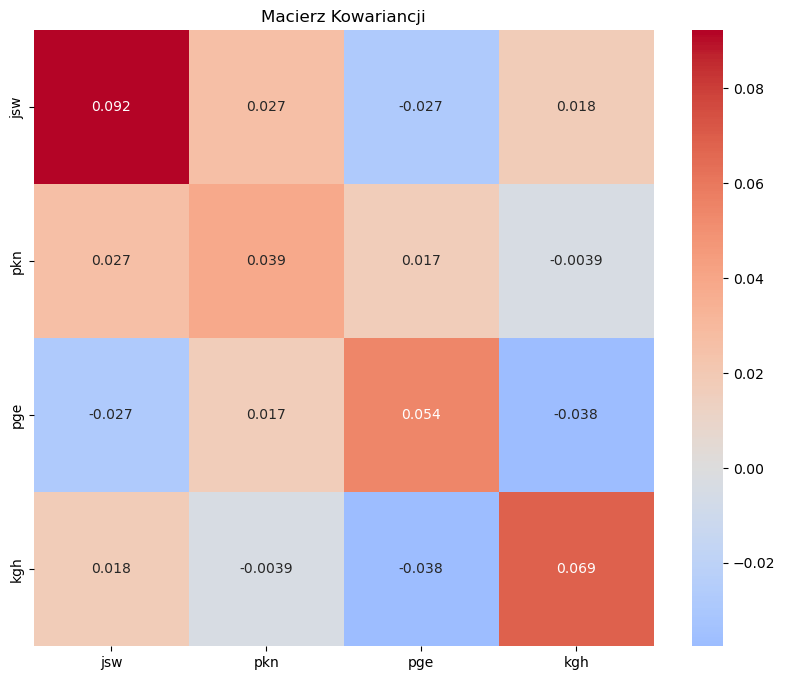

In [9]:
#Wizualizacja macierzy kowariancji jako heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_cov_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Macierz Kowariancji')
plt.show()

<Figure size 1200x800 with 0 Axes>

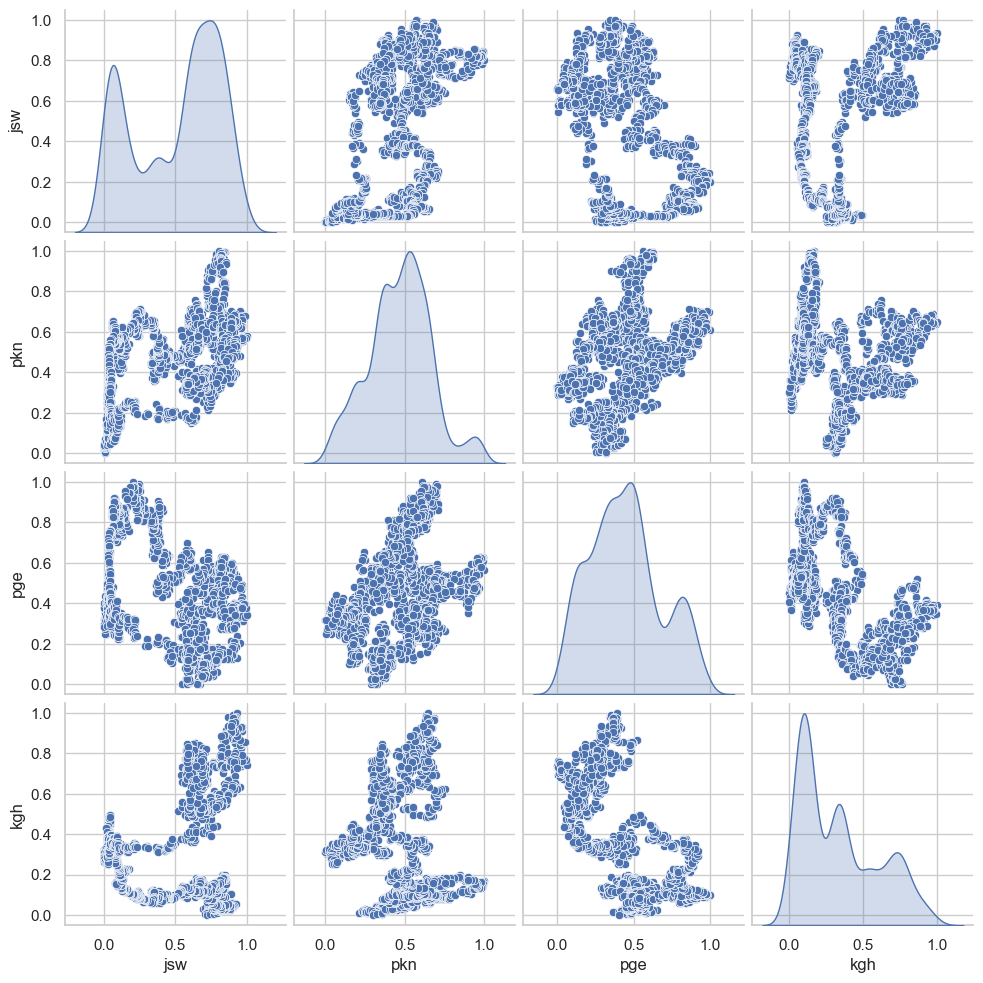

In [10]:
# Tworzenie scatter plotów z zaznaczonymi outlierami
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
scatter = sns.pairplot(scaled_data, diag_kind='kde')

# Znajdowanie i zaznaczanie outlierów
for ax in scatter.axes.flat:
    if ax.get_legend():
        for line in ax.get_legend().get_lines():
            x, y = line.get_xydata().T
            # Znajdowanie indeksów outlierów
            outliers = selected_data.index[(selected_data[x.name] == x.max()) | (selected_data[y.name] == y.max())]
            # Zaznaczanie outlierów
            ax.plot(x[outliers], y[outliers], 'ro', markersize=8)

plt.show()

Macierz Korelacji:
          jsw       pkn       pge       kgh
jsw  1.000000  0.445447 -0.387333  0.224036
pkn  0.445447  1.000000  0.372151 -0.076228
pge -0.387333  0.372151  1.000000 -0.613916
kgh  0.224036 -0.076228 -0.613916  1.000000


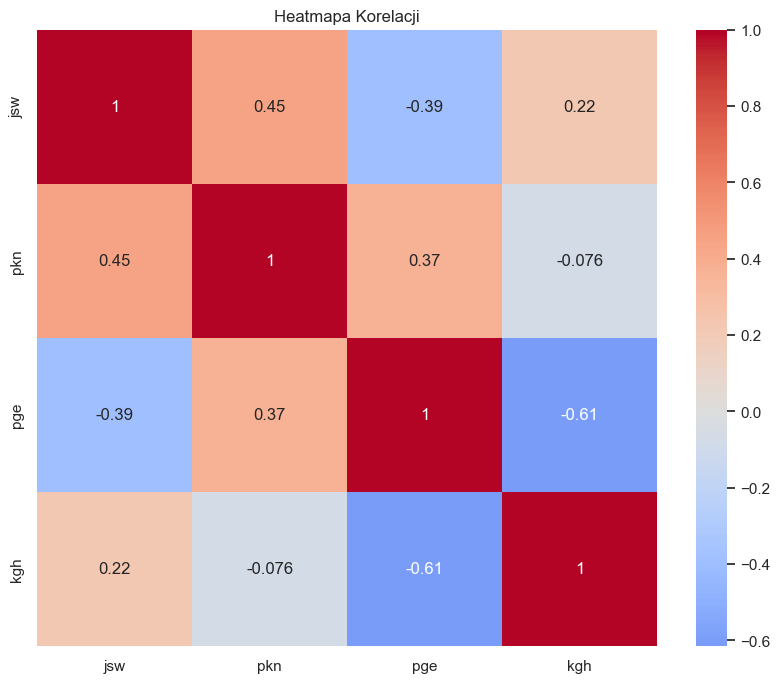

In [11]:
#Obliczenie korelacji
corr_matrix = scaled_data.corr()
print("Macierz Korelacji:")
print(corr_matrix)

# Tworzenie heatmapy korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Heatmapa Korelacji")
plt.show()

SW vs PKN (0.445): Wartość korelacji między JSW a PKN wynosi 0.445, co sugeruje umiarkowaną pozytywną korelację między ich "daily return". Oznacza to, że w okresach wzrostu wartości dla spółki JSW, często możemy obserwować podobny wzrost wartości dla spółki PKN. Jednak ta korelacja nie jest zbyt silna.
PGE vs KGH (-0.614): Wartość korelacji między PGE a KGH wynosi -0.614, co sugeruje umiarkowanie silną negatywną korelację. Gdy wartość dziennego zwrotu  dla spółki PGE rośnie, wartości akcji dla spółki KGH mają tendencję do spadku i vice versa. Ta korelacja może wskazywać na pewne przeciwności w zachowaniach tych spółek na rynku.
PKN vs KGH (-0.076): Wartość korelacji między PKN a KGH wynosi -0.076, co wskazuje na niemal brak korelacji lub bardzo słabą negatywną korelację. 

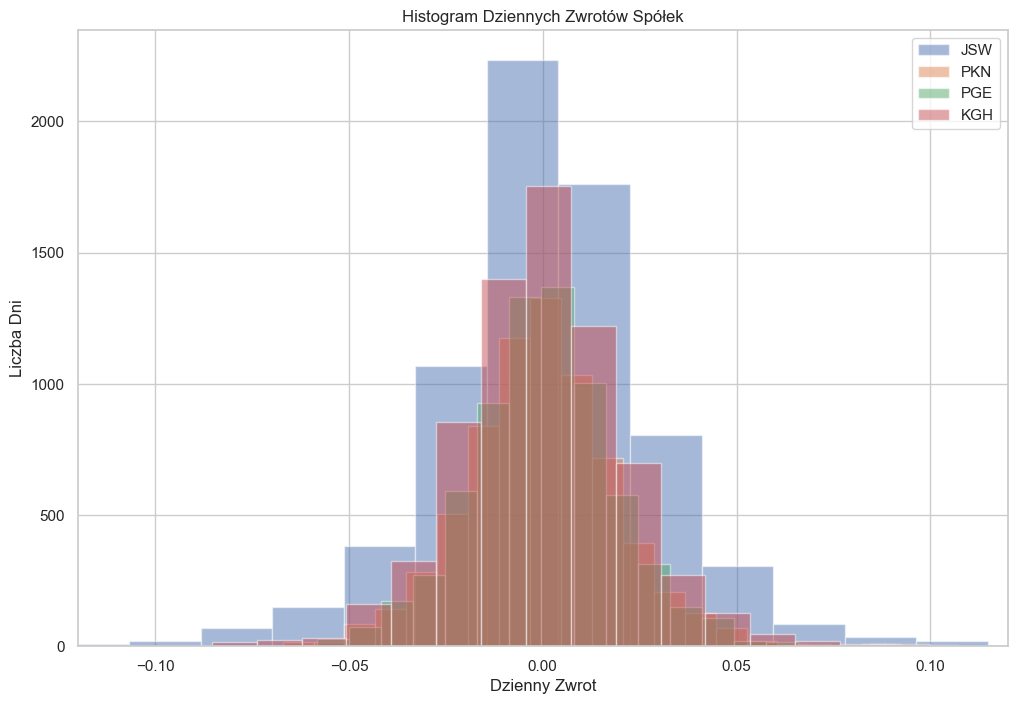

In [12]:
# Oblicz dzienny zwrot cen zamknięcia
df['Daily Return JSW'] = df[df['Symbol'] == 'jsw']['Close'].pct_change()
df['Daily Return PKN'] = df[df['Symbol'] == 'pkn']['Close'].pct_change()
df['Daily Return PGE'] = df[df['Symbol'] == 'pge']['Close'].pct_change()
df['Daily Return KGH'] = df[df['Symbol'] == 'kgh']['Close'].pct_change()

# Tworzenie histogramów dla dziennych zwrotów
# Tworzenie histogramów dla dziennych zwrotów
plt.figure(figsize=(12, 8))
plt.hist(df['Daily Return JSW'].dropna(), bins=20, alpha=0.5, label='JSW')
plt.hist(df['Daily Return PKN'].dropna(), bins=20, alpha=0.5, label='PKN')
plt.hist(df['Daily Return PGE'].dropna(), bins=20, alpha=0.5, label='PGE')
plt.hist(df['Daily Return KGH'].dropna(), bins=20, alpha=0.5, label='KGH')
plt.xlabel('Dzienny Zwrot')
plt.ylabel('Liczba Dni')
plt.title('Histogram Dziennych Zwrotów Spółek')
plt.legend()
plt.xlim(-0.12, 0.12)  # Set the x-axis range from -0.1 to 0.1
plt.show()

Na histogramie widać rozkład dziennych zwrotów cen zamknięcia dla poszczególnych spółek. Histogram przedstawia, w jakim stopniu i w jakim zakresie zmieniają się ceny akcji każdej spółki w ciągu jednego dnia.

Najciekawsza charakterystyka:
JSW wypada najciekawiej, ponieważ jego histogram zawiera skrajne wartości zarówno wzrostu, jak i spadku cen. To sugeruje, że spółka jest bardziej podatna na znaczne zmiany cen, co może być interesującym obszarem dla inwestorów poszukujących okazji do handlu na krótką lub długą metę. Jednakże, takie znaczne zmiany cen mogą również wiązać się z wyższym ryzykiem inwestycyjnym.


# Przygotowanie Danych do Uczenia

In [13]:
# Dodaj kolumnę z ceną zamknięcia jutrzejszą jako dzisiejszą cenę zamknięcia
df['Tomorrow_Close'] = df['Close'].shift(-1)
df = df.dropna(subset=['Tomorrow_Close'])

# Wybierz kolumnę, którą chcesz przewidywać (Tommorow_Close)
target_col = 'Tomorrow_Close'


# Inicjalizacja LabelEncoder
label_encoder = LabelEncoder()

df = df.copy()

# Przekształcenie kolumny 'Symbol' na wartości numeryczne
df.loc[:, 'Symbol_encoded'] = label_encoder.fit_transform(df['Symbol'])

# Wybierz cechy, w tym zakodowaną kolumnę 'Symbol_encoded'
feature_cols = ['High', 'Low', 'Close', 'Volume', 'Symbol_encoded']

# Inicjalizacja list do przechowywania wyników

mse_scores = []
mape_scores = []

# podzial zbioru na treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['Tomorrow_Close'], test_size=0.33, shuffle=False)

# MODEL BASELINE

In [14]:
# Oblicz błąd średniokwadratowy (MSE)
mse1 = ((df['Tomorrow_Close'] - df['Close']) ** 2).mean()

# Oblicz procentowy błąd bezwzględny (MAPE)
mape1 = (np.abs(df['Tomorrow_Close'] - df['Close']) / df['Close']).mean() * 100
formatted_mape = "{:.2f}%".format(mape1)
print(f"Procentowy błąd bezwzględny (MAPE): {formatted_mape}")
print(f"Błąd średniokwadratowy (MSE): {mse1}")

Procentowy błąd bezwzględny (MAPE): 1.72%
Błąd średniokwadratowy (MSE): 2.604763912124731


# LINEAR REGRESSION

In [15]:
# Inicjalizacja i trenowanie modelu Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred = model.predict(X_test)

# Obliczenie metryk jakości modelu
mse2 = mean_squared_error(y_test, y_pred)

# Oblicz procentowy błąd bezwzględny (MAPE)
mape2 = (abs((y_test - y_pred) / y_test).mean()) * 100    
mse_scores.append(mse2)
mape_scores.append(mape2)


# Wyświetlenie wyników
formatted_mape = "{:.2f}%".format(mape2)
print(f"Procentowy błąd bezwzględny (MAPE): {formatted_mape}")
print(f"Błąd średniokwadratowy (MSE): {mse2}")



Procentowy błąd bezwzględny (MAPE): 0.96%
Błąd średniokwadratowy (MSE): 3.2322012414749155


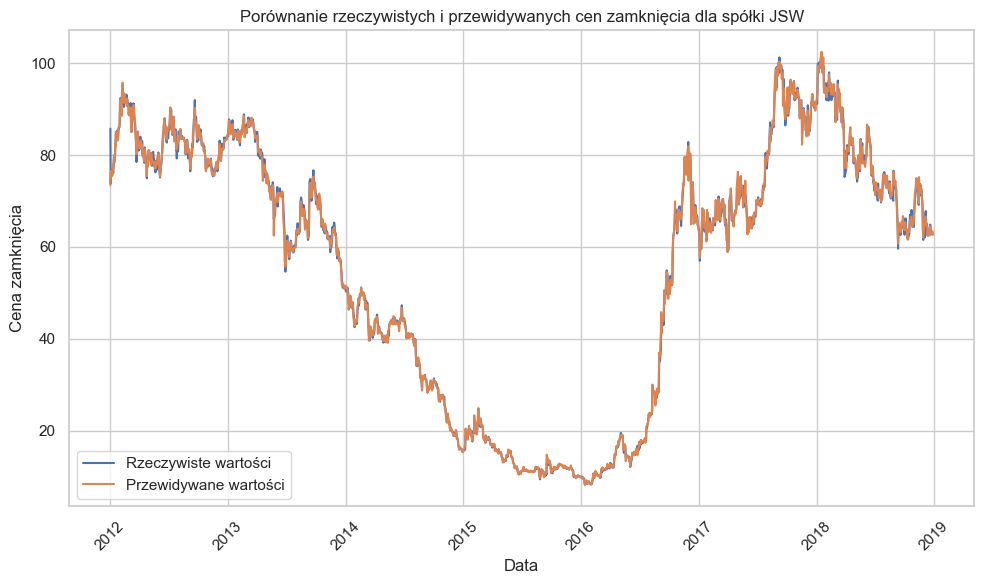

In [16]:
# Wybierz dane tylko dla spółki JSW
jsw_data = df[df['Symbol'] == 'jsw']

# Przewidywanie na danych testowych dla spółki JSW
y_jsw_pred = model.predict(jsw_data[feature_cols])

# Narysuj wykres porównania cen rzeczywistych i przewidywanych dla spółki JSW
plt.figure(figsize=(10, 6))
plt.plot(jsw_data.index, jsw_data['Tomorrow_Close'], label='Rzeczywiste wartości')
plt.plot(jsw_data.index, y_jsw_pred, label='Przewidywane wartości')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.title('Porównanie rzeczywistych i przewidywanych cen zamknięcia dla spółki JSW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

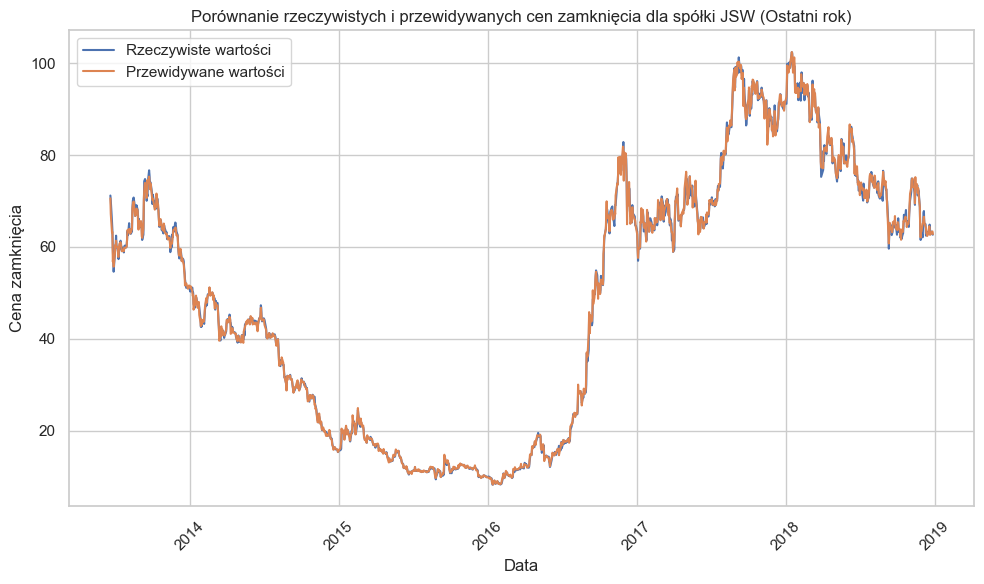

In [17]:
# Wybierz dane tylko dla spółki JSW
jsw_data = df[df['Symbol'] == 'jsw']

# Ograniczenie do ostatniego roku
last_year_data = jsw_data[jsw_data.index >= jsw_data.index[-365]]

# Przewidywanie na danych testowych dla spółki JSW
y_jsw_pred = model.predict(last_year_data[feature_cols])

# Narysuj wykres porównania cen rzeczywistych i przewidywanych dla spółki JSW
plt.figure(figsize=(10, 6))
plt.plot(last_year_data.index, last_year_data['Tomorrow_Close'], label='Rzeczywiste wartości')
plt.plot(last_year_data.index, y_jsw_pred, label='Przewidywane wartości')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.title('Porównanie rzeczywistych i przewidywanych cen zamknięcia dla spółki JSW (Ostatni rok)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Podjąłem decyzję o skorzystaniu z prostego modelu Linear Regression, wyniki tego modelu nie są zadowalające i rodzą pewne wątpliwości co do jego efektywności. Średni błąd średniokwadratowy (MSE) w okolicach 1.03 wskazuje, że istnieją znaczne rozbieżności między przewidywanymi wynikami a rzeczywistymi wartościami. Wysoka wartość tego wskaźnika sugeruje, że model nie jest w stanie odpowiednio uwzględnić złożonych wzorców w danych, co może prowadzić do błędnych prognoz. Jednak bardziej obiecującym wskaźnikiem dla tego modelu jest procentowy błąd bezwzględny (MAPE) na poziomie 1.07%. To oznacza, że przewidywane wartości są średnio o 1.07% różne od rzeczywistych wartości. Choć Linear Regression może być wykorzystywany w prostych przypadkach, to  w przypadku analizy giełdowej jest on zbyt ograniczony, by dobrze przewidzieć wyniki na podstawie dostępnych informacji. 

# RANDOM FOREST REGRESSOR

In [18]:
# Definiowanie siatki parametrów do przeszukania
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicjalizacja modelu Random Forest Regressor
model = RandomForestRegressor()
model.fit(X_train, y_train)


# Inicjalizacja RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,  # liczba losowych kombinacji parametrów do przetestowania
    scoring='neg_mean_squared_error',  # lub inna metryka
    n_jobs=-1,  # równoległe przetwarzanie
    cv=5,  # liczba podziałów walidacji krzyżowej
)
# Trenowanie modelu z RandomizedSearchCV
random_search.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred1 = random_search.predict(X_test)

# Obliczenie metryk jakości modelu
mse = mean_squared_error(y_test, y_pred1)
mape3 = (abs((y_test - y_pred1) / y_test).mean()) * 100

# Wyświetlenie wyników

formatted_mape = "{:.2f}%".format(mape3)
print(f"Procentowy błąd bezwzględny (MAPE): {formatted_mape}")
print(f"Średni błąd średniokwadratowy (MSE): {mse}")
print("Najlepsze parametry:", random_search.best_params_)

Procentowy błąd bezwzględny (MAPE): 4.70%
Średni błąd średniokwadratowy (MSE): 125.99842602763736
Najlepsze parametry: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 30}


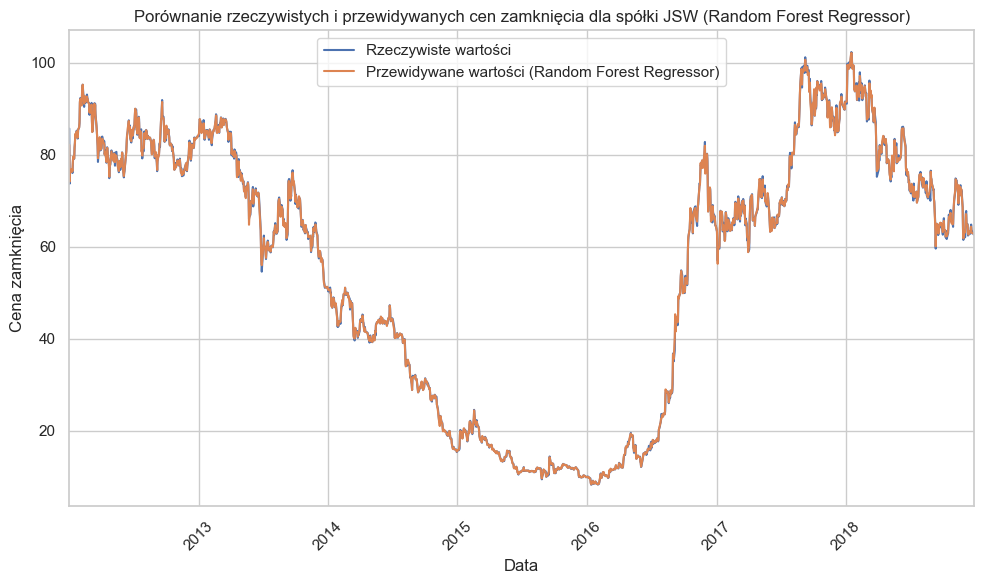

In [19]:
# Wybierz dane tylko dla spółki JSW
jsw_data = df[df['Symbol'] == 'jsw']

# Przewidywanie na danych testowych dla spółki JSW z Random Forest Regressor
y_jsw_pred_rf = model.predict(jsw_data[feature_cols])

# Narysuj wykres porównania cen rzeczywistych i przewidywanych dla spółki JSW (Random Forest Regressor)
plt.figure(figsize=(10, 6))
plt.plot(jsw_data.index, jsw_data['Tomorrow_Close'], label='Rzeczywiste wartości')
plt.plot(jsw_data.index, y_jsw_pred_rf, label='Przewidywane wartości (Random Forest Regressor)')
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.title('Porównanie rzeczywistych i przewidywanych cen zamknięcia dla spółki JSW (Random Forest Regressor)')
plt.legend()
plt.xticks(rotation=45)

# Ograniczenie osi X do danych testowych, zachowując kolejność chronologiczną
plt.xlim(jsw_data.index[-1], jsw_data.index[-len(y_test):][0])

plt.tight_layout()
plt.show()


Postanowiłem skorzystać z modelu Random Forest Regressor w celu prognozowania wyników na podstawie dostępnych danych. w moim przypadku nie jestem pewien, czy jest to najlepszy wybór. Choć wyniki nie są tragiczne, to jednak nie mogę ukryć pewnych wątpliwości - (MSE) na poziomie 50.50 wskazuje, że istnieje znaczna rozbieżność między przewidywanymi wartościami a rzeczywistymi wynikami. To może sugerować, że model nie jest w stanie dokładnie odzwierciedlić złożonych zależności w danych, co wpływa na dokładność prognoz.
Procentowy błąd bezwzględny (MAPE) wynoszący około 4.60% jest również istotnym wskaźnikiem oceny modelu. Choć ta wartość może wydawać się niska, w kontekście analizy giełdowej i prognozowania cen akcji, taki poziom błędu jest bardzo niekorzystny.
Chociaż Random Forest Regressor jest popularnym modelem, niekoniecznie znaczy to, że jest idealny do każdego problemu. W moim przypadku, zastanawiam się, czy istnieją bardziej zaawansowane modele, które lepiej radziłyby sobie z przewidywaniem wyników. 

Procentowy błąd bezwzględny Baseline(MAPE1): 1.7215263873976445%
Błąd średniokwadratowy Baseline(MSE1): 2.604763912124731

Procentowy błąd bezwzględny LinearRegression(MAPE2): 0.9642732403672429%
Błąd średniokwadratowy LinearRegression(MSE2): 3.2322012414749155

Procentowy błąd bezwzględny RandomForestRegressor(MAPE3): 4.700125580339766%
Błąd średniokwadratowy RandomForestRegressor(MSE3): 125.99842602763736



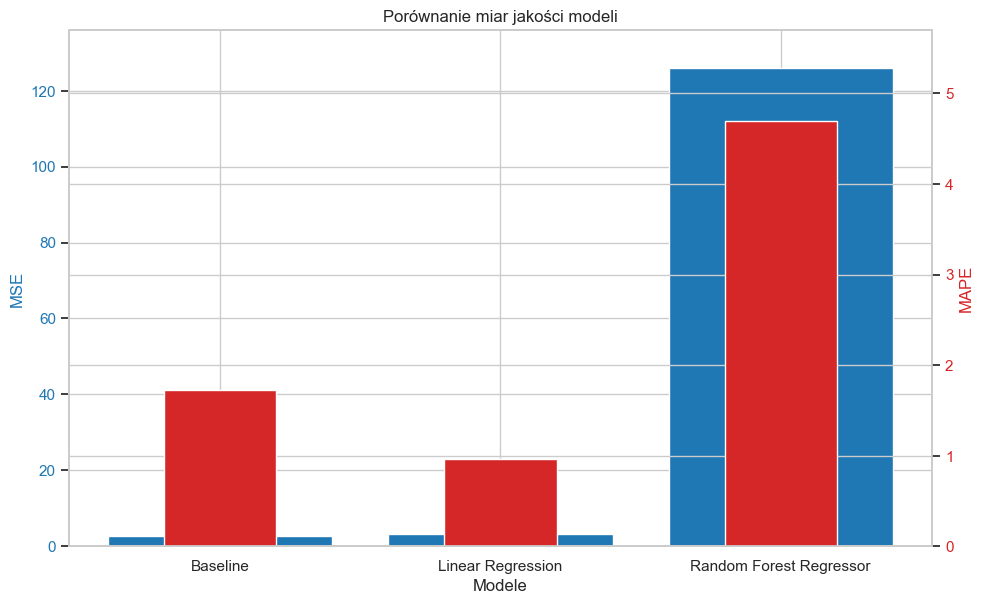

In [20]:
#obliczenia metryk
mse1 = ((df['Tomorrow_Close'] - df['Close']) ** 2).mean()
mape1 = (np.abs(df['Tomorrow_Close'] - df['Close']) / df['Close']).mean() * 100
mse2 = mean_squared_error(y_test, y_pred)
mape2 = (abs((y_test - y_pred) / y_test).mean()) * 100
mse3 = mean_squared_error(y_test, y_pred1)
mape3 = (abs((y_test - y_pred1) / y_test).mean()) * 100

# Wyświetlenie wyników
print(f"Procentowy błąd bezwzględny Baseline(MAPE1): {mape1}%")
print(f"Błąd średniokwadratowy Baseline(MSE1): {mse1}\n")

print(f"Procentowy błąd bezwzględny LinearRegression(MAPE2): {mape2}%")
print(f"Błąd średniokwadratowy LinearRegression(MSE2): {mse2}\n")

print(f"Procentowy błąd bezwzględny RandomForestRegressor(MAPE3): {mape3}%")
print(f"Błąd średniokwadratowy RandomForestRegressor(MSE3): {mse3}\n")

# Wyniki metryk dla różnych modeli i wartości bazowej
models = ['Baseline', 'Linear Regression', 'Random Forest Regressor']
mse_values = [mse1, mse2, mse3]
mape_values = [mape1, mape2, mape3]

# Wykres porównania miar jakości modeli
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Modele')
ax1.set_ylabel('MSE', color=color)
ax1.bar(models, mse_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Dodanie oddzielnego słupka dla MAPE
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('MAPE', color=color)
ax2.bar(models, mape_values, color=color, width=0.4)  # Oddzielne słupki dla MAPE
ax2.tick_params(axis='y', labelcolor=color)

# Skalowanie wartości dla czytelności na wykresie
ax1.set_ylim(0, max(mse_values) + 10)  # Ustawienie limitu dla osi Y dla MSE
ax2.set_ylim(0, max(mape_values) + 1)  # Ustawienie limitu dla osi Y dla MAPE

fig.tight_layout()
plt.title('Porównanie miar jakości modeli')
plt.show()

Model bazowy to punkt odniesienia, który służy do porównania z innymi modelami. Pokazuje nam, jak bardzo mylimy się, gdy staramy się przewidzieć ceny na jutro, opierając się tylko na dzisiejszych cenach. Dla naszych testowych danych model bazowy popełnia błąd wynoszący około 1.72%. To oznacza, że nasze przewidywania różnią się od rzeczywistych cen o tę wartość. Innymi słowy, gdybyśmy użyli prostego podejścia opartego na dzisiejszych cenach, nasze przewidywania byłyby o 1.72% dalekie od rzeczywistości.

Linear Regression trochę lepszy niż ten podstawowy. Nasz błąd spada do 0.96%, co wskazuje, że nasze przewidywania są bliższe prawdziwym cenom. Niemniej jednak, wciąż popełniamy pewne błędy, a nasze przewidywania różnią się od rzeczywistości. Błąd średniokwadratowy wynoszący 3.23 wskazuje, że są pewne różnice między naszymi przewidywaniami a rzeczywistymi wartościami.


Random Forest Regressor Model sprawdza się gorzej niż poprzednie dwa. Błąd wynosi już 4.65%, więc nasze przewidywania są bardziej oddalone od rzeczywistych wartości. Błąd średniokwadratowy 121.96 jest dość duży, co sugeruje, że ten model ma poważne trudności z przewidywaniem. To pokazuje, że model może nie radzić sobie z analizą skomplikowanych wzorców na giełdzie.

Podsumowując, żaden z tych modeli nie jest idealny, ale model regresji liniowej wypada najlepiej spośród trzech. Jednak w analizie giełdowej potrzebujemy bardziej zaawansowanych narzędzi, aby dokładniej przewidywać zmiany cen.


#    Wnioski i Podsumowanie


Żaden z analizowanych modeli (Linear Regression, RandomForestRegressor) w podstawowej konfiguracji nie nadaje się jako godne zaufania narzędzie do przewidywania zmian cen akcji na giełdzie. Złożoność i nieliniowość tego typu danych sprawiają, że tradycyjne modele matematyczne nie są wystarczające do precyzyjnego prognozowania ruchów cen akcji. Rynki finansowe są pod wpływem wielu czynników, a ich dynamika często jest trudna do przewidzenia. W związku z tym, podejście oparte na analizie technicznej, fundamentalnej i wiedzy eksperckiej jest równie istotne, jak próba modelowania matematycznego. Dla tak skomplikowanego środowiska, podejście hybrydowe lub bardziej zaawansowane techniki analizy danych mogą być bardziej obiecujące.

# Następne kroki

W tym projekcie została poruszona tylko mała część narzędzi do rozwiązania problemu jakim jest prognozowanie zmian cen akcji. Pobrałem i uporządkowałem dane oraz stworzyłem trzy modele  do testowania strategii inwestycyjnych.

Istnieje wiele kroków, które można podjąć, aby poprawić oczekiwane prognozy.
W pierwszej kolejnosci zastosowałbym krosswalidacje. 
Dodałbym dużo więcej wskaźników z analizy technicznej jako "wsad" do uczenia modelu.
Moglibyśm wziąć pod uwagę również wskaźniki ekonomiczne np. zmiany stóp procentowych.

Ciekawe wydaje się uwzględniać w modelu ważne dla spółki daty tj. wypłacane dywidendy, czy jakieś zewnętrzne wydarzenia, jak wybory a moze daty wprowadzania szalonych ustaw jak historia z JSW.


# Dodatek

Dodanie RSI do modelu a wplyw na wyniki


In [21]:
# Funkcja do obliczania wskaźnika RSI
def calculate_rsi(data, period=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Oblicz wskaźnik RSI dla danych
df['RSI'] = calculate_rsi(df['Close'])
df = df.dropna(subset=['RSI'])

In [22]:
df = df.reset_index(drop=True)

# Wybierz kolumnę, którą chcesz przewidywać (Close)
target_col = 'Close'


# Inicjalizacja LabelEncoder
label_encoder = LabelEncoder()

# Przekształcenie kolumny 'Symbol' na wartości numeryczne
df['Symbol_encoded'] = label_encoder.fit_transform(df['Symbol'])

# Wybierz cechy, w tym zakodowaną kolumnę 'Symbol_encoded'
feature_cols2 = ['High', 'Low', 'Volume', 'Symbol_encoded', 'RSI']

# Inicjalizacja walidacji krzyżowej TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Inicjalizacja list do przechowywania wyników

mse_scores = []
mape_scores = []

# podzial zbioru na treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols2], df['Tomorrow_Close'], test_size=0.33, shuffle=False)

In [23]:
# Inicjalizacja i trenowanie modelu Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred = model.predict(X_test)

# Oblicz procentowy błąd bezwzględny (MAPE)
mape2 = (abs((y_test - y_pred) / y_test).mean()) * 100    
mape_scores.append(mape2)


# Wyświetlenie wyników
formatted_mape = "{:.2f}%".format(mape2)
print(f"Procentowy błąd bezwzględny (MAPE): {formatted_mape}")

Procentowy błąd bezwzględny (MAPE): 1.07%


In [32]:
# Inicjalizacja i trenowanie modelu Random Forest Regressor
model = RandomForestRegressor(n_estimators=20)
model.fit(X_train, y_train)
    
# Przewidywanie na danych testowych
y_pred1 = model.predict(X_test)


# Oblicz procentowy błąd bezwzględny (MAPE)
mape2 = (abs((y_test - y_pred1) / y_test).mean()) * 100    
mape_scores.append(mape2)


# Wyświetlenie wyników
formatted_mape = "{:.2f}%".format(mape2)
print(f"Procentowy błąd bezwzględny (MAPE): {formatted_mape}")



Procentowy błąd bezwzględny (MAPE): 4.62%


Dodanie tylko jednego wskaznika analizy technicznej RSI wprowadza wiekszą zmieność w dostarczanych danych  co daje gorszy wynik MAPE dla modelu regresji liniowej uzyskane MAPE 1.07%> 0,96%, z kolei korzystniej(minimalnie) wpływa na zmniejszenie błędów przy Random Forest Regressor 4.62%<4.65%.
